In [1]:
import os
import sys

import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd
from models.TrainPlanningOperator2D import PlanningOperator2D
from heuristics import generaterandompos
from heuristics import euclideannorm, FMM, dijkstra, planningoperator, manhattandistance
from heuristics import testheuristiconmaps, testheuristiconsinglemap



Load Test Maps

In [2]:
Ntotal = 550
ntest = 50
ntrain = 250
sub = 1
Sx = Sy = int(((512 - 1) / sub) + 1)
maps = np.load('/mountvol/2D-512-Dataset-0/mask.npy')
maps = maps[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]
# maps = maps[30:31,:,:].reshape(1,Sx,Sy)

Generate Random Start and Goal Positions on Maps

In [3]:
# startpositions = generaterandompos(maps)
# goalpositions = generaterandompos(maps)

# np.save('/mountvol/2D-512-Dataset-0/startpositions.npy', startpositions)
# np.save('/mountvol/2D-512-Dataset-0/goalpositions.npy', goalpositions)

Load Saved Start and Goal Positions

In [3]:
startpositions = np.load('/mountvol/2D-512-Dataset-0/startpositions.npy')
goalpositions = np.load('/mountvol/2D-512-Dataset-0/goalpositions.npy')

Comparing Euclidean and Manhattan Distance

In [4]:
# Euclidean Norm
print("Testing Euclidean Norm")
euclidean_results = testheuristiconmaps(startpositions, goalpositions, maps, euclideannorm, plotresults=False, printvalues=True)


Testing Euclidean Norm
Average Path Cost: 311.2137097306642 
Average Planning Time: 1.6279704618453978 
Average Inference Time: 0.025503668785095215 
Average Number of Node Expansions: 14850.22 
Average Success Rate: 1.0


Planning Operator

In [5]:
# Model
modes = 8
width = 24
nlayers = 1

model = PlanningOperator2D(modes, modes, width, nlayers)
model.load_state_dict(torch.load("/mountvol/2D-512-Dataset-0/planningoperator_street_maps_512x512_8m_12w_1l_b20/n500_lr5.000000e-03_gamma5.000000e-01_wd3.000000e-06_seed5/model256.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

erosion_values = []
avgpathcost_values = []
avgplantime_values = []
avginfertime_values = []
avgnodesexp_values = []
avgsuccessrate_values = []



/tmp/ipykernel_13970/697047691.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/mountvol/2D-512-Dataset-0/planningoperator_street_maps_

No erosion

In [9]:
print("Testing PNO")
no_results = testheuristiconmaps(startpositions, goalpositions, maps, planningoperator, plotresults=False, printvalues=True, erosion = 1, model=model)

Testing PNO
Average Path Cost: 315.24885691692197 
Average Planning Time: 0.5168617153167725 
Average Inference Time: 0.06795791149139405 
Average Number of Node Expansions: 8882.32 
Average Success Rate: 1.0


With Erosion

In [10]:
print("Testing PNO")
no_results = testheuristiconmaps(startpositions, goalpositions, maps, planningoperator, plotresults=False, printvalues=True, erosion = 14, model=model)

Testing PNO
Average Path Cost: 311.72400410317954 
Average Planning Time: 0.6143115568161011 
Average Inference Time: 0.04933128833770752 
Average Number of Node Expansions: 9869.62 
Average Success Rate: 1.0


100%|██████████| 29/29 [01:24<00:00,  2.91s/it]


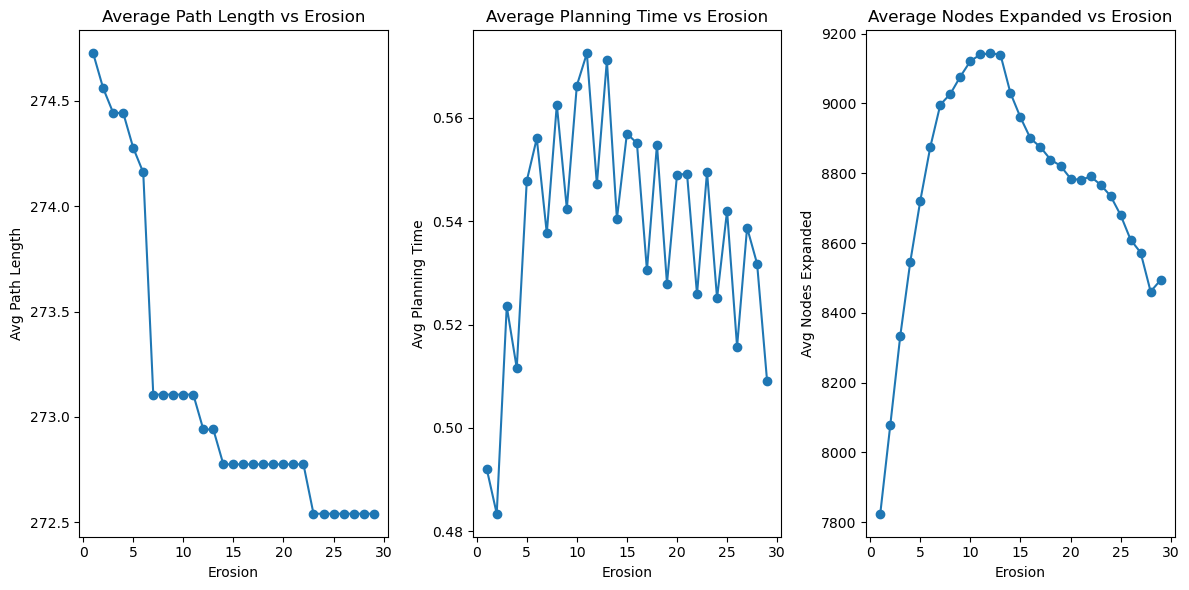

In [7]:

from tqdm import tqdm 

erosionmaps = maps[::10, :, :]
erosionstartpos = startpositions[::10,:]
erosiongoalpos = goalpositions[::10,:]

erosion_values = []
avgpathcost_values = []
avgplantime_values = []
avginfertime_values = []
avgnodesexp_values = []
avgsuccessrate_values = []

# Run the loop and store results
for erode in tqdm(range(1, 30)):
    
    # Call your function and store the results
    avgpathcost, avgplantime, avginfertime, avgnodesexp, avgsuccessrate = testheuristiconmaps(
        erosionstartpos, erosiongoalpos, erosionmaps, planningoperator, model=model, erosion=erode, plotresults=False, printvalues=False
    )
    
    # Append results to lists
    erosion_values.append(erode)
    avgpathcost_values.append(avgpathcost)
    avgplantime_values.append(avgplantime)
    avginfertime_values.append(avginfertime)
    avgnodesexp_values.append(avgnodesexp)
    avgsuccessrate_values.append(avgsuccessrate)

plt.figure(figsize=(12, 6))

# Plot for avgpathcost (Average Path Length)
plt.subplot(1, 3, 1)
plt.plot(erosion_values, avgpathcost_values, marker='o')
plt.title('Average Path Length vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Path Length')

# Plot for avgplantime (Average Planning Time)
plt.subplot(1, 3, 2)
plt.plot(erosion_values, avgplantime_values, marker='o')
plt.title('Average Planning Time vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Planning Time')

# Plot for avgnodesexp (Average Nodes Expanded)
plt.subplot(1, 3, 3)
plt.plot(erosion_values, avgnodesexp_values, marker='o')
plt.title('Average Nodes Expanded vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Nodes Expanded')

plt.tight_layout()
plt.show()

In [9]:
import pickle
data = {
    "startpositions": startpositions,
    "goalpositions": goalpositions,
    "maps": maps,
    "euclidean_results": euclidean_results,
    "no_results": no_results,
    "erosion_values": erosion_values,
    "avgpathcost_values": avgpathcost_values,
    "avgplantime_values": avgplantime_values,
    "avginfertime_values": avginfertime_values,
    "avgnodesexp_values": avgnodesexp_values,
    "avgsuccessrate_values": avgsuccessrate_values
}

# Save to file using pickle, ignoring the model
with open("512mapstest.pkl", "wb") as file:
    pickle.dump(data, file)

print("Data saved successfully to '256maps.pkl'")

Data saved successfully to '256maps.pkl'


Test Single Maps

[[191  63]]
[[372 386]]
Plotting Euclidean Norm
Average Path Cost: 411.3452377915616 
Average Planning Time: 3.0951523780822754 
Average Inference Time: 0.018072128295898438 
Average Number of Node Expansions: 28787.0 
Average Success Rate: 1.0


(411.3452377915616, 3.0951523780822754, 0.018072128295898438, 28787.0, 1.0)

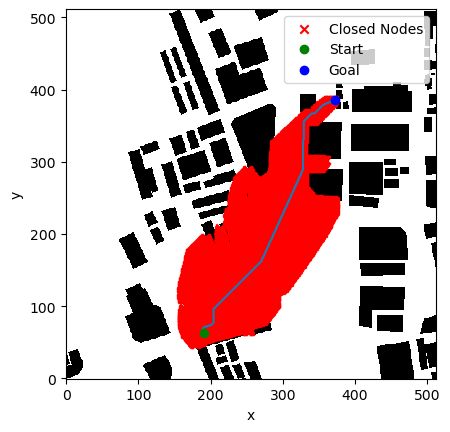

In [90]:
maptest = maps[0,:,:].reshape(1,Sx,Sy)
starttest = startpositions[0,:].reshape(1,2)
goaltest = goalpositions[0,:].reshape(1,2)
starttest = np.array([[491,482]])
goaltest = np.array([[180,28]])

starttest = generaterandompos(maptest)
goaltest = generaterandompos(maptest)

print(starttest)
print(goaltest)

print("Plotting Euclidean Norm")
testheuristiconmaps(starttest, goaltest, maptest, euclideannorm, plotresults=True, printvalues=True, saveplotdata = False)

Plotting PNO
Average Path Cost: 412.1736649163078 
Average Planning Time: 1.4457378387451172 
Average Inference Time: 0.11516451835632324 
Average Number of Node Expansions: 13143.0 
Average Success Rate: 1.0


(412.1736649163078, 1.4457378387451172, 0.11516451835632324, 13143.0, 1.0)

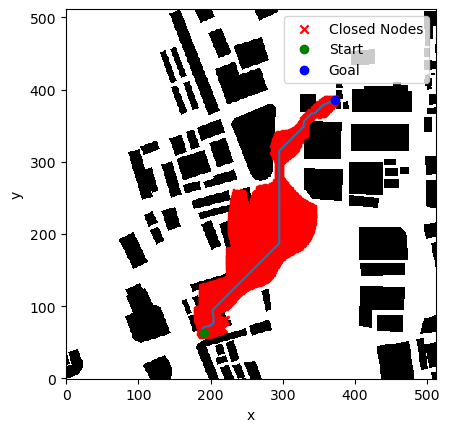

In [91]:
print("Plotting PNO")
testheuristiconmaps(starttest, goaltest, maptest, planningoperator, plotresults=True, printvalues=True, erosion = 1, model=model, saveplotdata=False)

Plotting PNO
Average Path Cost: 411.34523779156166 
Average Planning Time: 1.4423060417175293 
Average Inference Time: 0.08838820457458496 
Average Number of Node Expansions: 13290.0 
Average Success Rate: 1.0


(411.34523779156166, 1.4423060417175293, 0.08838820457458496, 13290.0, 1.0)

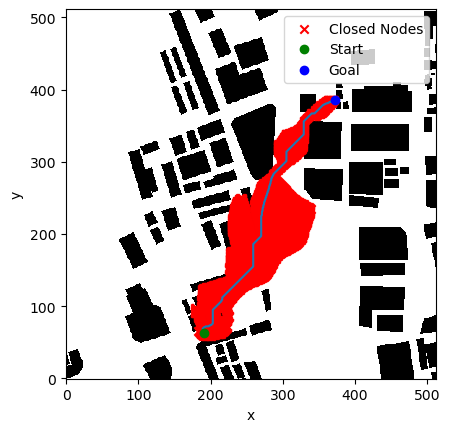

In [92]:
print("Plotting PNO")
testheuristiconmaps(starttest, goaltest, maptest, planningoperator, plotresults=True, printvalues=True, erosion = 3, model=model, saveplotdata=False)

Average Path Cost: 411.3452377915617 
Average Planning Time: 1.4344470500946045 
Average Inference Time: 0.3503377437591553 
Average Number of Node Expansions: 13264.0 
Average Success Rate: 1.0


(411.3452377915617, 1.4344470500946045, 0.3503377437591553, 13264.0, 1.0)

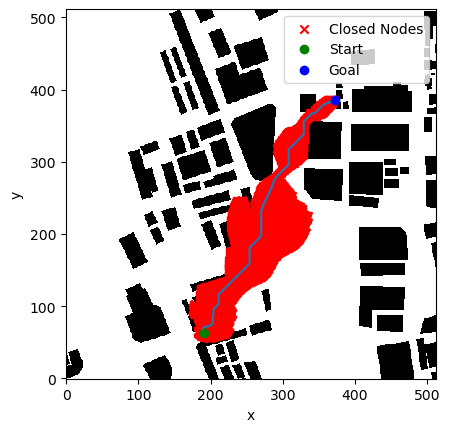

In [93]:
testheuristiconmaps(starttest, goaltest, maptest, planningoperator, plotresults=True, printvalues=True, erosion = 5, model=model, saveplotdata=False)